In [1023]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

import torch.utils.data
from sklearn.model_selection import train_test_split

import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [1024]:
train_csv = pd.read_csv("Train.csv", keep_default_na=False)
test_csv = pd.read_csv("Test.csv", keep_default_na=False)

# train = train[0:30]
print(train_csv.dtypes)
#print(train_csv['traffic_volume'])

date_time               object
is_holiday              object
air_pollution_index      int64
humidity                 int64
wind_speed               int64
wind_direction           int64
visibility_in_miles      int64
dew_point                int64
temperature            float64
rain_p_h               float64
snow_p_h               float64
clouds_all               int64
weather_type            object
weather_description     object
traffic_volume           int64
dtype: object


In [1025]:
test_csv.shape

(14454, 14)

In [1026]:
train_csv.shape

(33750, 15)

In [1027]:
def preprocess_data(dataset):
    #dataset['Power'] = dataset["Power"].replace("bhp", "", regex=True).replace("null", "", regex=True)
    #dataset['Power'] = pd.to_numeric(dataset["Power"].str.strip())
    #dataset['Engine'] = dataset["Engine"].replace("CC", "", regex=True)
    #dataset['Engine'] = pd.to_numeric(dataset["Engine"].str.strip())
    #dataset['Mileage'] = dataset["Mileage"].apply(convertKgtoL)
    #dataset['Mileage'] = pd.to_numeric(dataset["Mileage"])
    #dataset['New_Price'] = dataset["New_Price"].apply(convertKgtoL)
    #dataset['New_Price'] = pd.to_numeric(dataset["New_Price"])
   
    dataset = dataset.replace('NaN', '')
    dataset = dataset.replace('0', '')
    dataset['weather_description'] = dataset["weather_description"].replace(" ", "_", regex=True).str.lower()
    dataset['is_holiday'] = dataset["is_holiday"].replace(" ", "_", regex=True).str.lower()    

    for col in list(dataset.columns):
        if dataset[col].dtype == np.float64 or dataset[col].dtype == np.int64:
            dataset[col] = pd.to_numeric(dataset[col])
            dataset[col] = dataset[col].mask(dataset[col]<=0)
    
    dataset.sort_values("date_time", inplace=True) 
    dataset.drop_duplicates(subset=['date_time'], keep = False, inplace = True) 
    dataset = dataset.drop(['date_time'],axis=1)
    #dataset = dataset.drop(['Year'],axis=1)
    return dataset

In [1028]:
train = preprocess_data(train_csv)
test = preprocess_data(test_csv)

display(train.head())
#train.columns

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,none,121,89,2.0,329.0,1,1,288.28,NaN,NaN,40.0,Clouds,scattered_clouds,5545.0
1,none,178,67,3.0,330.0,1,1,289.36,NaN,NaN,75.0,Clouds,broken_clouds,4516.0
2,none,113,66,3.0,329.0,2,2,289.58,NaN,NaN,90.0,Clouds,overcast_clouds,4767.0
3,none,20,66,3.0,329.0,5,5,290.13,NaN,NaN,90.0,Clouds,overcast_clouds,5026.0
4,none,281,65,3.0,329.0,7,7,291.14,NaN,NaN,75.0,Clouds,broken_clouds,4918.0


In [1029]:
for c in ["weather_description", "is_holiday"]:
    lbl = LabelEncoder() 
    lbl.fit(list(np.concatenate((train[c].values, test[c].values), axis=None))) 
    train[c] = lbl.transform(list(train[c].values))
    test[c] = lbl.transform(list(test[c].values))


In [1030]:
train.shape

(24951, 14)

In [1031]:
train['traffic_volume'].describe()

count    24949.000000
mean      3295.226342
std       1984.002804
min          1.000000
25%       1284.000000
50%       3418.000000
75%       4959.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [1032]:
print("Skewness: %f" % train['traffic_volume'].skew())
print("Kurtosis: %f" % train['traffic_volume'].kurt())

Skewness: -0.101549
Kurtosis: -1.289895


In [1033]:
train.dtypes

is_holiday               int64
air_pollution_index      int64
humidity                 int64
wind_speed             float64
wind_direction         float64
visibility_in_miles      int64
dew_point                int64
temperature            float64
rain_p_h               float64
snow_p_h               float64
clouds_all             float64
weather_type            object
weather_description      int64
traffic_volume         float64
dtype: object

In [1034]:
train.columns

Index(['is_holiday', 'air_pollution_index', 'humidity', 'wind_speed',
       'wind_direction', 'visibility_in_miles', 'dew_point', 'temperature',
       'rain_p_h', 'snow_p_h', 'clouds_all', 'weather_type',
       'weather_description', 'traffic_volume'],
      dtype='object')

In [1035]:
#combined_set = pd.concat([train, test], axis=0, ignore_index=True)

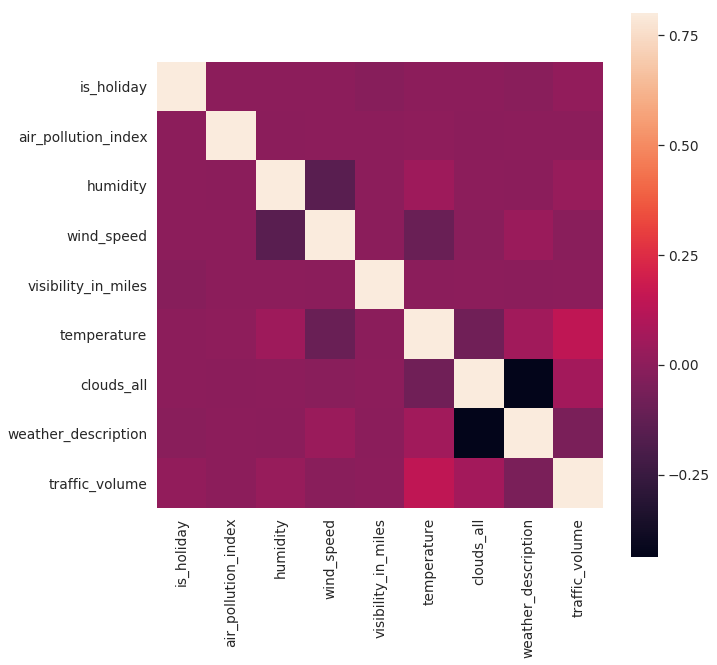

In [1036]:
corcolm = ['is_holiday', 'air_pollution_index', 'humidity', 'wind_speed',
       'visibility_in_miles', 'temperature', 'clouds_all', 'weather_description', 'traffic_volume'];

#correlation matrix
corrmat = train[corcolm].corr()
#corrmat = train.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True);


In [1037]:
#combined_set = combined_set[corcolm]
#train = train[corcolm]

total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
snow_p_h,24946,0.999800
rain_p_h,24010,0.962286
clouds_all,1927,0.077231
wind_speed,986,0.039517
wind_direction,680,0.027253
temperature,10,0.000401
traffic_volume,2,0.000080
weather_description,0,0.000000
weather_type,0,0.000000
dew_point,0,0.000000


In [1038]:
train = train.interpolate(method ='linear', limit_direction ='both')

In [1039]:
train.isnull().sum().max() #just checking that there's no missing data missing...

0

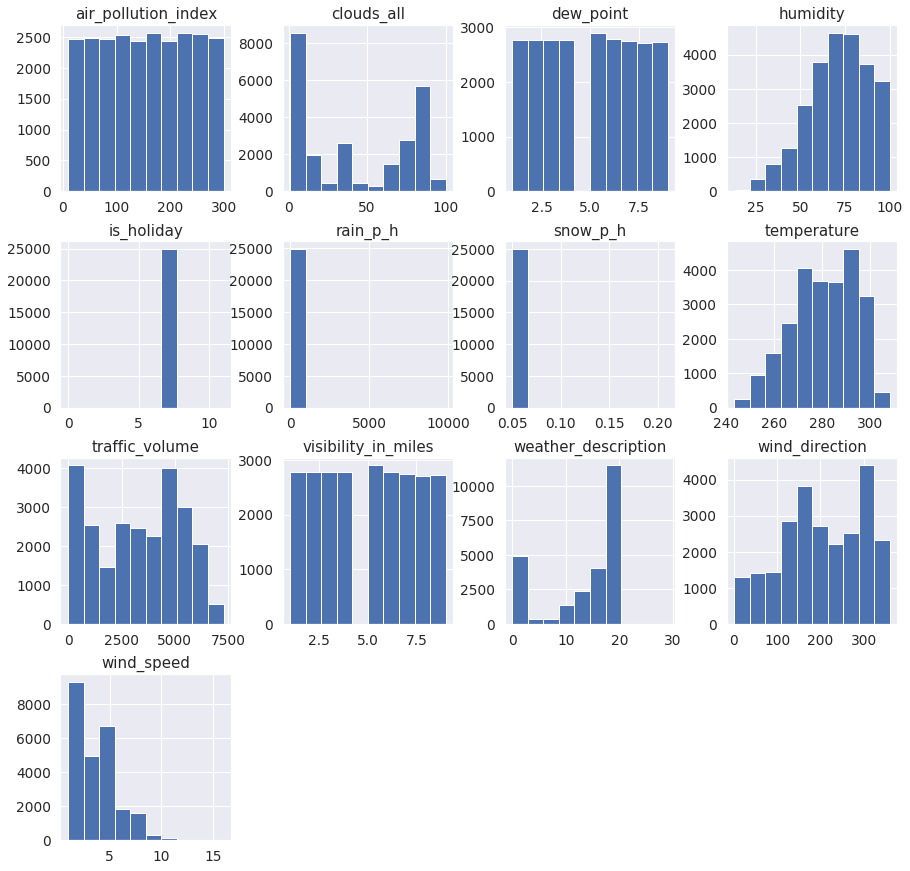

In [1040]:
train.hist(figsize=(15, 15))
plt.show()

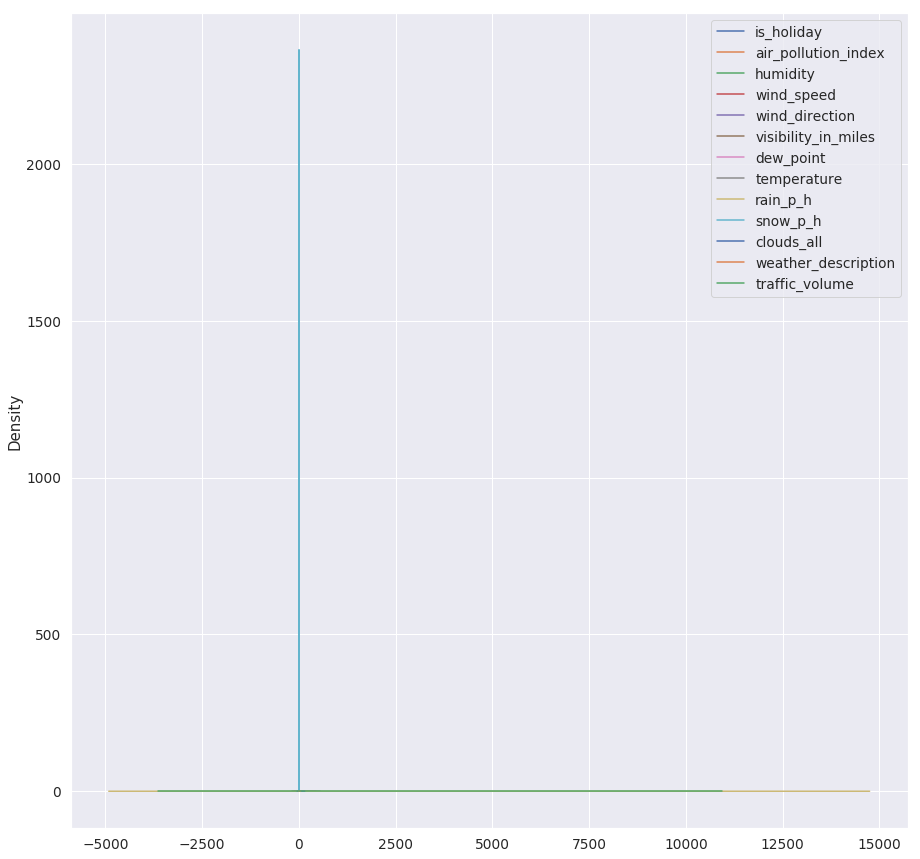

In [1041]:
train.plot.kde(figsize=(15, 15))
plt.show()

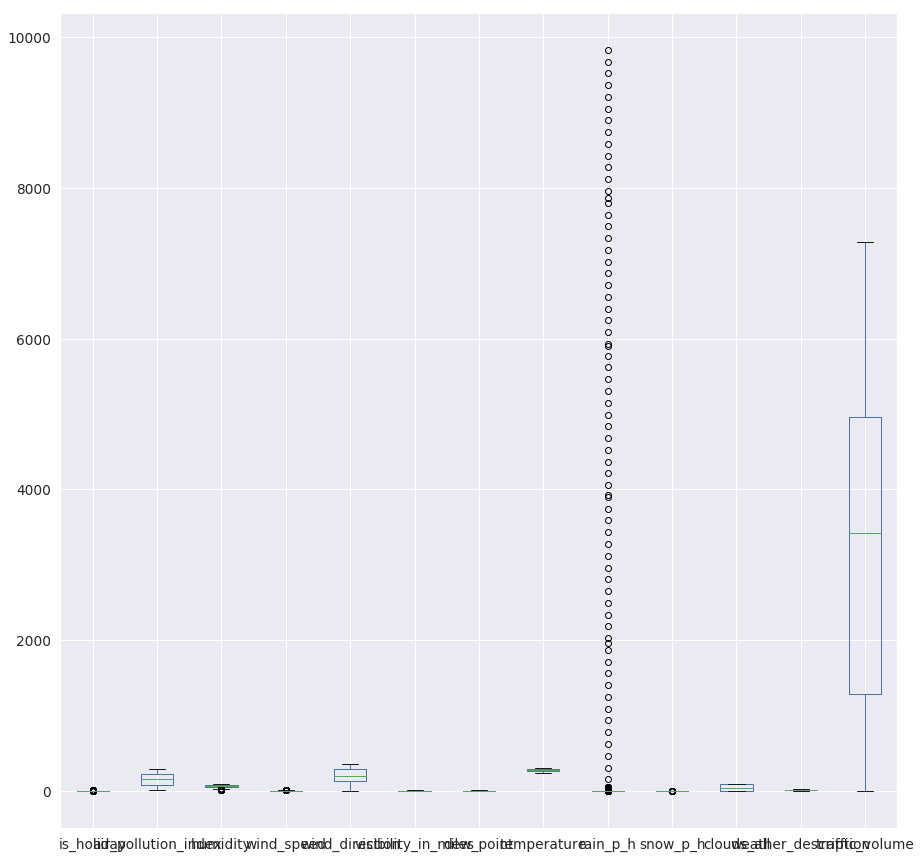

In [1042]:
train.plot.box(figsize=(15, 15))
plt.show()

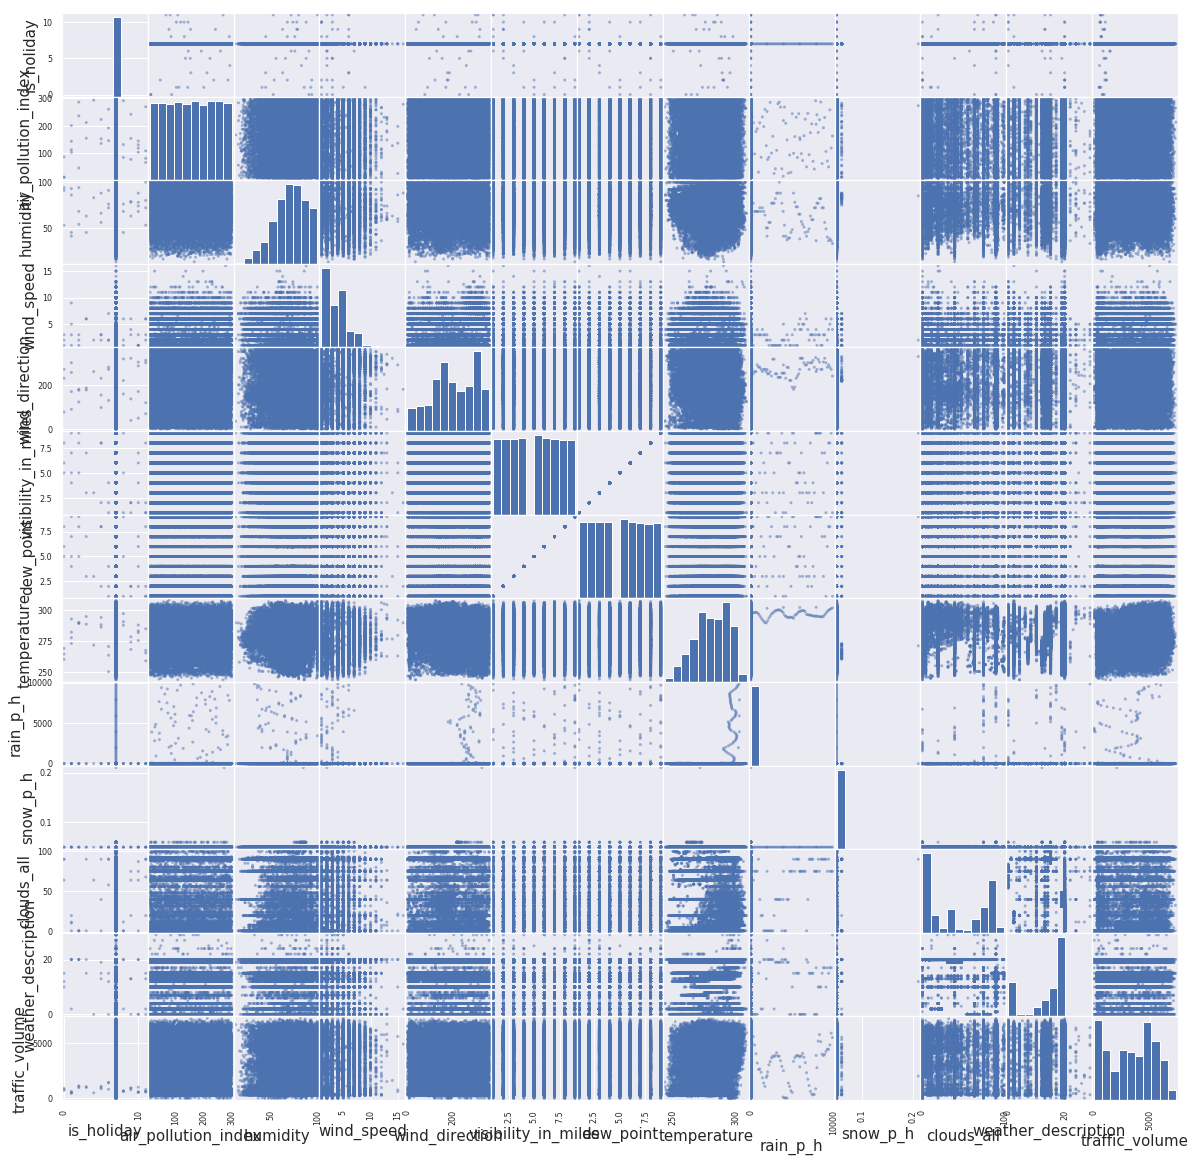

In [1043]:
scatter_matrix(train, figsize=(20, 20))
plt.show()

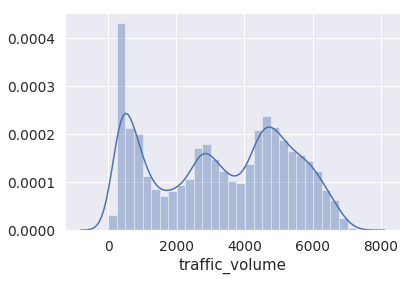

In [1044]:
sns.distplot(train['traffic_volume']);

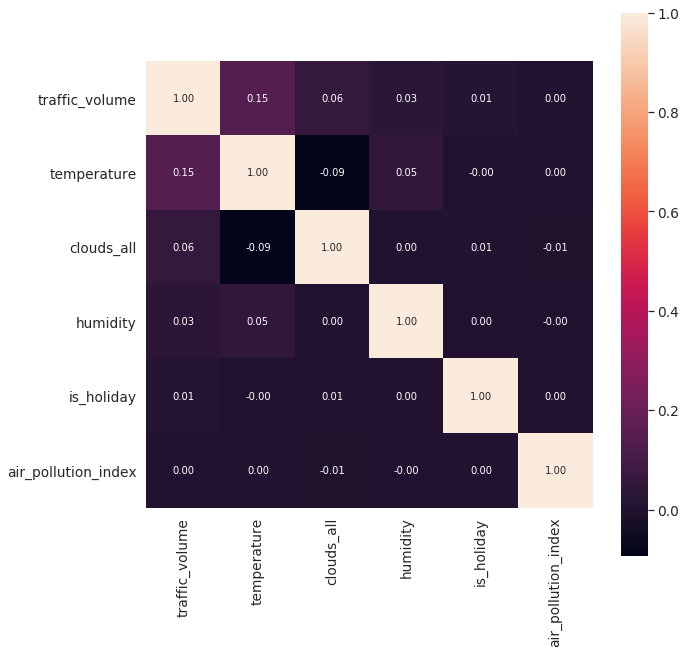

In [1045]:
#saleprice correlation matrix
k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'traffic_volume')['traffic_volume'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(10, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [1046]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(train['traffic_volume'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.66017755]
 [-1.66017755]
 [-1.66017755]
 [-1.66017755]
 [-1.66017755]
 [-1.66017755]
 [-1.66017755]
 [-1.65967355]
 [-1.65967355]
 [-1.65967355]]

outer range (high) of the distribution:
[[1.92683472]
 [1.93086677]
 [1.93288279]
 [1.94245891]
 [1.94296292]
 [1.94497894]
 [1.96261916]
 [1.97673134]
 [1.98882748]
 [2.00848373]]


In [1047]:
col_train_num = list(cols)
#col_train_num.append("is_holiday")
#col_train_num.append("weather_type")
#col_train_num.append("weather_description")

col_train_num_bias = list(cols)
#col_train_num_bias.append("is_holiday")
#col_train_num_bias.append("weather_type")
#col_train_num_bias.append("weather_description")
col_train_num_bias.remove('traffic_volume')

print(col_train_num_bias)

#test = test[col_train_num_bias]
#train = train[col_train_num]

train = train[col_train_num]
test = test[col_train_num_bias]
test = test.interpolate(method ='linear', limit_direction ='both')
#test = test.interpolate(method ='linear', limit_direction ='both') 
#scatter_matrix(train[col_train_num], figsize=(25, 25))
#plt.show()
#test.isnull().sum().max()

['temperature', 'clouds_all', 'humidity', 'is_holiday', 'air_pollution_index']


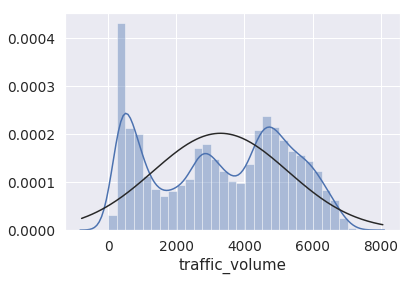

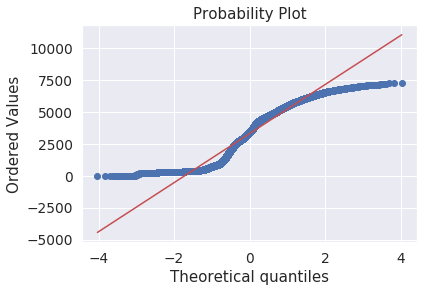

In [1048]:
from scipy import stats
#histogram and normal probability plot
sns.distplot(train['traffic_volume'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['traffic_volume'], plot=plt)

traffic_volume
temperature
clouds_all
humidity
is_holiday
air_pollution_index


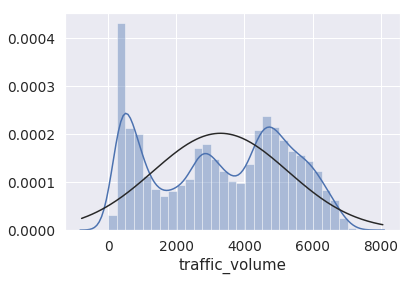

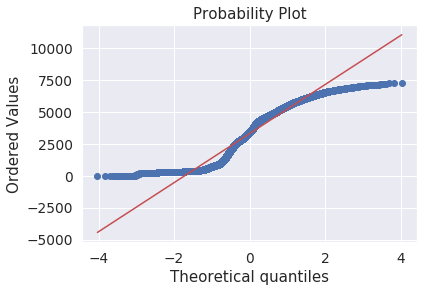

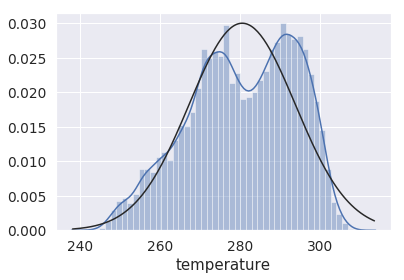

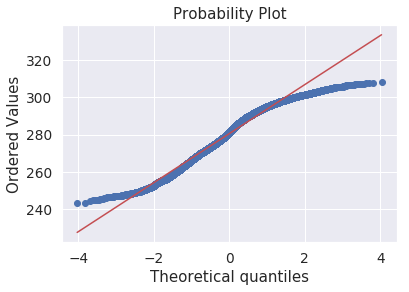

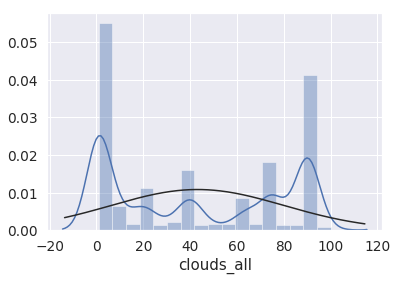

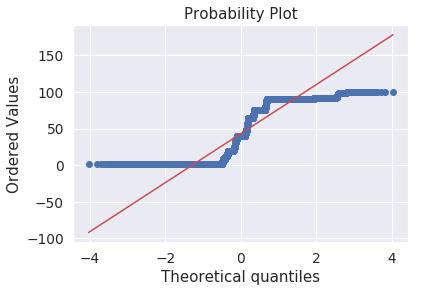

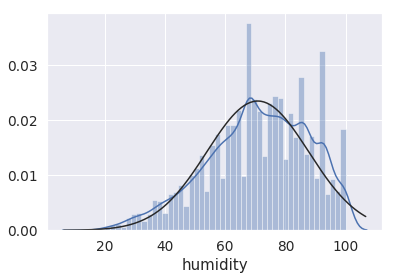

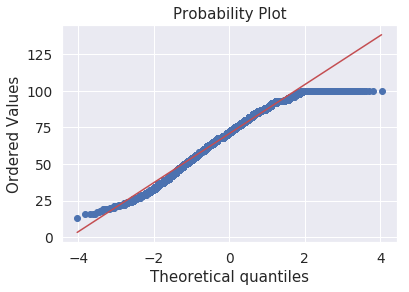

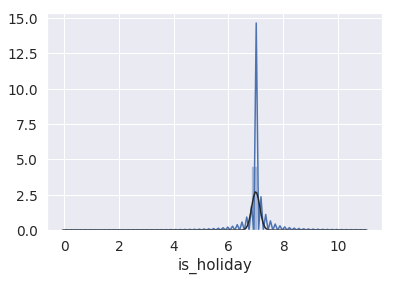

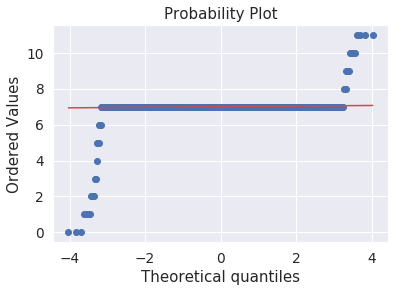

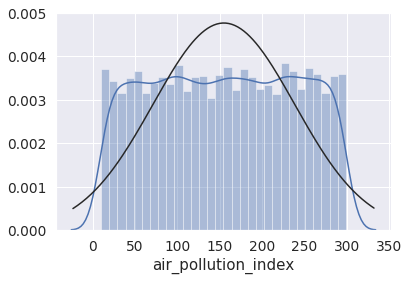

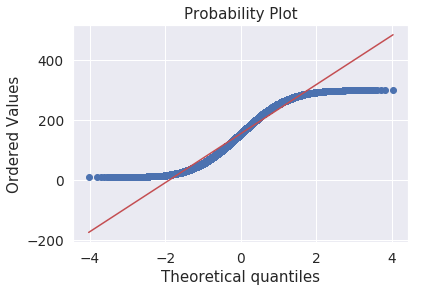

In [1049]:
#train_numerical = train.select_dtypes(exclude=['object'])

for col in col_train_num:
    print(col)
    try:
        plt.figure()
        sns.distplot(train[col], fit=stats.norm);
        fig = plt.figure()
        res = stats.probplot(train[col], plot=plt)
    except TypeError:
        print("No graph for this {} column".format(col))
    #fig = plt.figure()
    #stats.probplot(train[col], plot=plt)

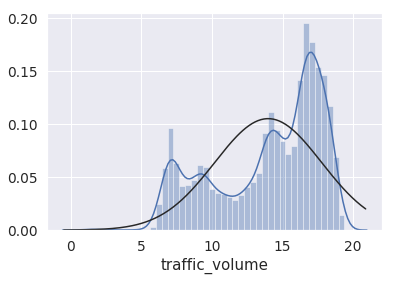

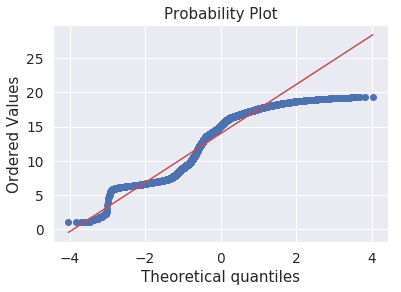

In [1050]:
train['traffic_volume'] = np.cbrt(train['traffic_volume'])
sns.distplot(train['traffic_volume'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['traffic_volume'], plot=plt)

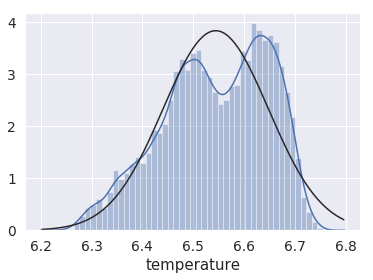

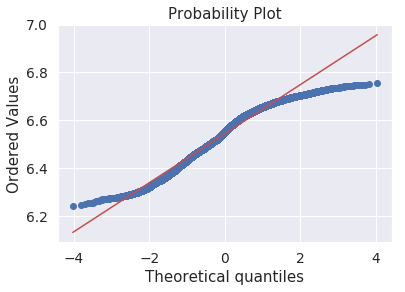

In [1051]:
train['temperature'] = np.cbrt(train['temperature'])
sns.distplot(train['temperature'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['temperature'], plot=plt)

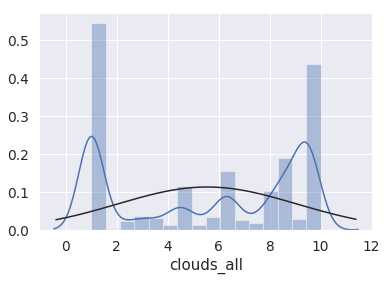

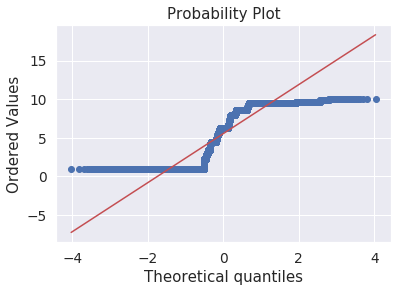

In [1052]:
train['clouds_all'] = np.sqrt(train['clouds_all'])
sns.distplot(train['clouds_all'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['clouds_all'], plot=plt)

In [1053]:
"""
combined_set['wind_speed'] = np.cbrt(combined_set['wind_speed'])
sns.distplot(combined_set['wind_speed'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(combined_set['wind_speed'], plot=plt)
"""

"\ncombined_set['wind_speed'] = np.cbrt(combined_set['wind_speed'])\nsns.distplot(combined_set['wind_speed'], fit=stats.norm);\nfig = plt.figure()\nres = stats.probplot(combined_set['wind_speed'], plot=plt)\n"

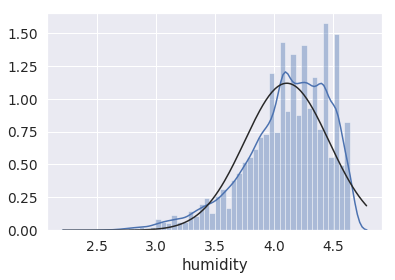

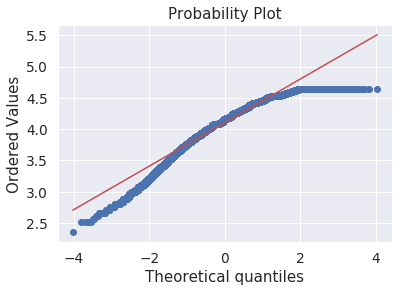

In [1054]:
train['humidity'] = np.cbrt(train['humidity'])
sns.distplot(train['humidity'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['humidity'], plot=plt)

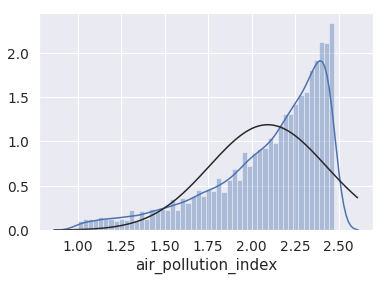

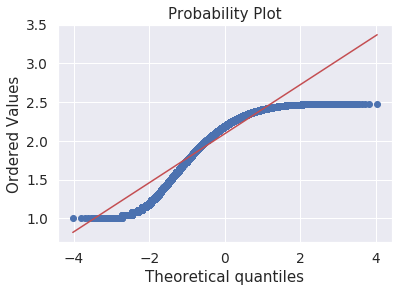

In [1055]:
train['air_pollution_index'] = np.log10(train['air_pollution_index'])
sns.distplot(train['air_pollution_index'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['air_pollution_index'], plot=plt)

In [1056]:
"""
train['PLUS_DI'] = np.log(train['PLUS_DI'])
test['PLUS_DI'] = np.log(test['PLUS_DI'])
sns.distplot(train['PLUS_DI'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['PLUS_DI'], plot=plt)
"""

"\ntrain['PLUS_DI'] = np.log(train['PLUS_DI'])\ntest['PLUS_DI'] = np.log(test['PLUS_DI'])\nsns.distplot(train['PLUS_DI'], fit=stats.norm);\nfig = plt.figure()\nres = stats.probplot(train['PLUS_DI'], plot=plt)\n"

In [1057]:
"""
train.loc[train['WILLR']>0, 'WILLR'] = np.log(train[train['WILLR']>0]['WILLR'])
sns.distplot(train['WILLR'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['WILLR'], plot=plt)
"""

"\ntrain.loc[train['WILLR']>0, 'WILLR'] = np.log(train[train['WILLR']>0]['WILLR'])\nsns.distplot(train['WILLR'], fit=stats.norm);\nfig = plt.figure()\nres = stats.probplot(train['WILLR'], plot=plt)\n"

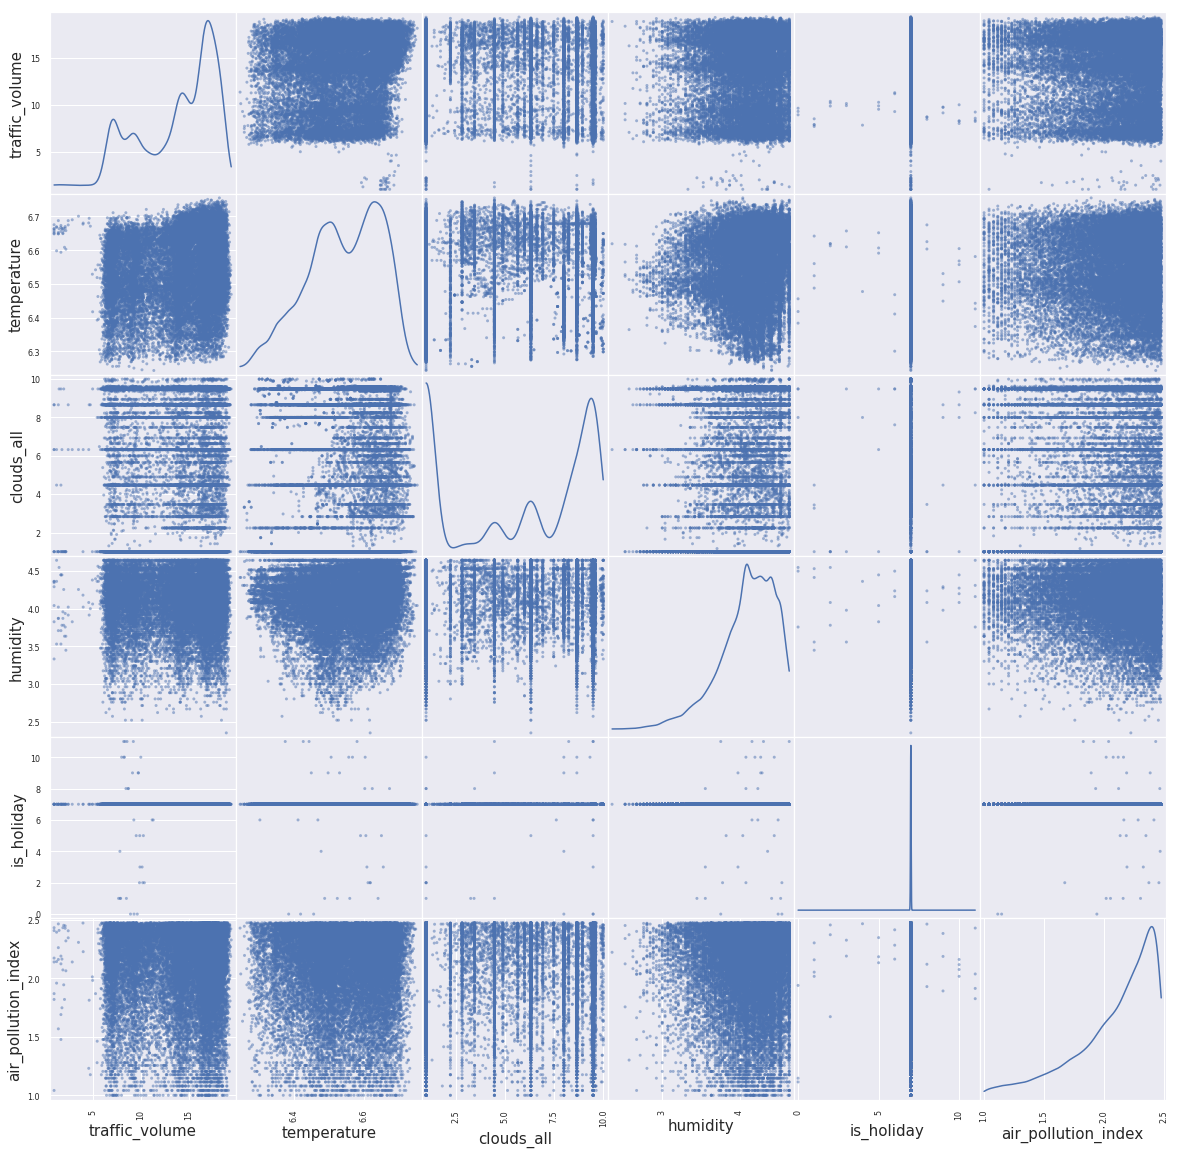

In [1058]:
scatter_matrix(train, figsize=(20, 20), diagonal="kde")
plt.show()

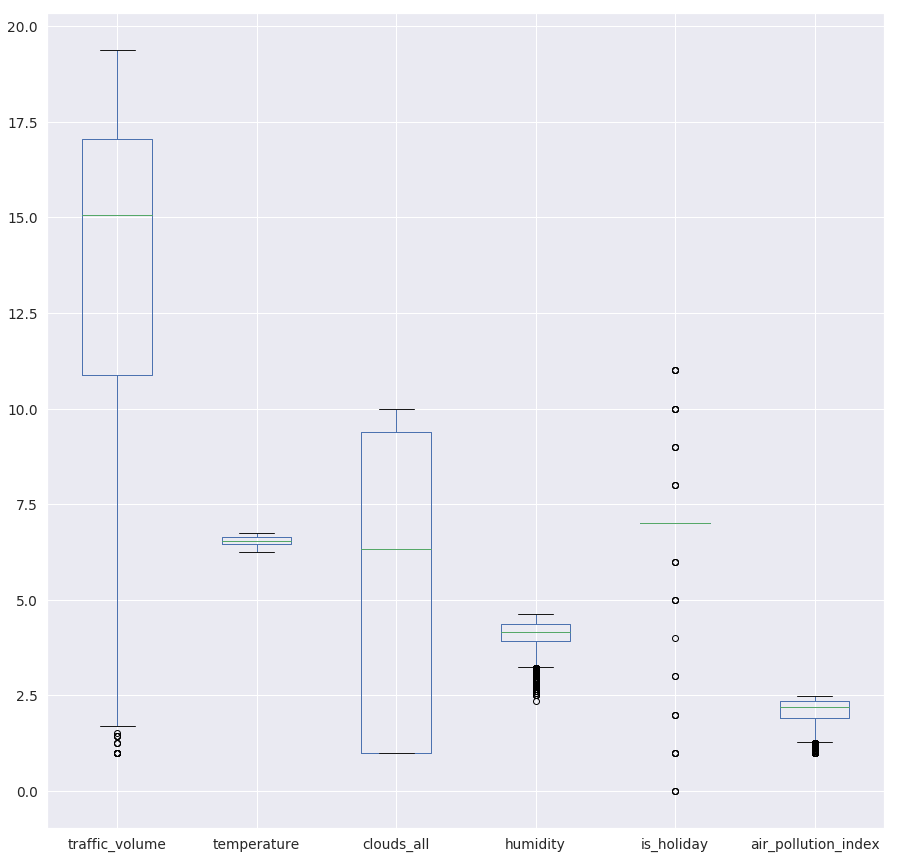

In [1059]:
train.plot.box(figsize=(15, 15))
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

traffic_volume
temperature
clouds_all
humidity


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


is_holiday
air_pollution_index


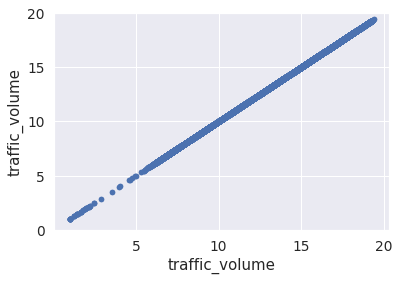

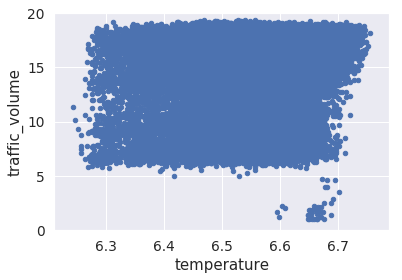

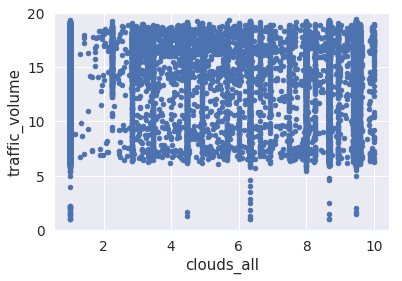

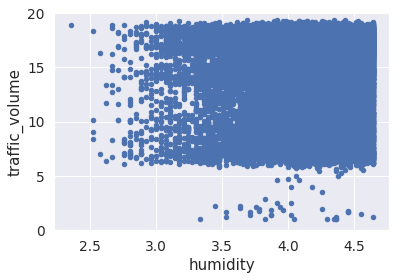

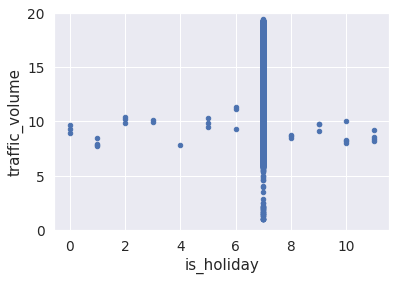

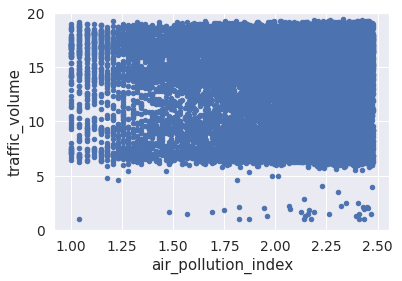

In [1060]:
for col in col_train_num:
    print(col)
    try:
        cm = plt.cm.get_cmap('RdYlBu')
        data = pd.concat([train['traffic_volume'], train[col]], axis=1)
        data.plot.scatter(x=col, y='traffic_volume', ylim=(0,20));
    except ValueError:
        print("No graph for this {} column".format(col))
        raise

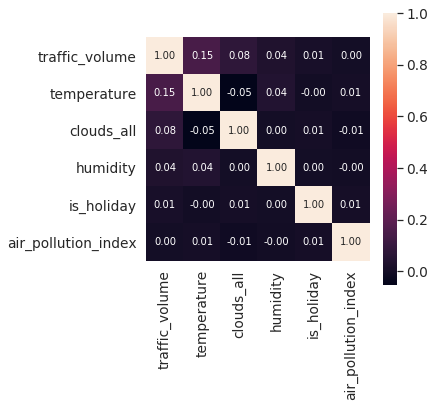

In [1061]:
corrmat_next = train.corr()
cols_next = corrmat_next.index
f, ax = plt.subplots(figsize=(5, 5))
hm = sns.heatmap(corrmat_next, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_next.values, xticklabels=cols_next.values)
plt.show()

In [1062]:
combined_set = pd.concat([train, test], axis=0, ignore_index=True)
#combined_set = pd.get_dummies(combined_set)
display(combined_set.head())

,air_pollution_index,clouds_all,humidity,is_holiday,temperature,traffic_volume
0,2.082785,6.324555,4.464745,7,6.605994,17.699752
1,2.250420,8.660254,4.061548,7,6.614233,16.529180
2,2.053078,9.486833,4.041240,7,6.615909,16.829907
3,1.301030,9.486833,4.041240,7,6.620095,17.129348
4,2.448706,8.660254,4.020726,7,6.627768,17.005765


In [1063]:
print(combined_set.shape)

train = combined_set[:24950]
test = combined_set[24951:]
test = test.drop("traffic_volume",axis = 1)

col_train = list(train.columns)
col_train_bis = list(train.columns)
col_train_bis.remove("traffic_volume")

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('traffic_volume',axis = 1))

mat_y = np.array(train.traffic_volume).reshape((24950,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

# trimed_test.to_csv("output_final_3.csv")
train_set = pd.DataFrame(prepro.transform(train),columns = col_train)

# test = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

test_set  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

display(train_set.head())

(35130, 6)


,air_pollution_index,clouds_all,humidity,is_holiday,temperature,traffic_volume
0,0.733758,0.591617,0.922784,0.636364,0.708545,0.908531
1,0.847357,0.851139,0.746735,0.636364,0.724654,0.844848
2,0.713627,0.942981,0.737868,0.636364,0.727930,0.861208
3,0.203995,0.942981,0.737868,0.636364,0.736114,0.877499
4,0.981727,0.851139,0.728911,0.636364,0.751116,0.870776


In [1064]:
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "traffic_volume"

#FEATURES.remove('Price')

# Training set and Prediction set with the features to predict
training_set = train_set[col_train]
prediction_set = training_set.traffic_volume

# print(prediction_set)

X_train, X_val, y_train, y_val = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.4)

train_set_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
val_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set_tensor,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)
val_test_loader = torch.utils.data.DataLoader(val_set,batch_size=1, shuffle=False)

In [1065]:
"""
train_numerical = train.select_dtypes(exclude=['object'])
train_numerical.fillna(0,inplace = True)
train_categoric = train.select_dtypes(include=['object'])
train_categoric.fillna('NONE',inplace = True)
train_new = train_numerical.merge(train_categoric, left_index = True, right_index = True)

test_numerical = test.select_dtypes(exclude=['object'])
test_numerical.fillna(0,inplace = True)
test_categoric = test.select_dtypes(include=['object'])
test_categoric.fillna('NONE',inplace = True)
test_new = test_numerical.merge(test_categoric, left_index = True, right_index = True) 

train.dtypes
"""

"\ntrain_numerical = train.select_dtypes(exclude=['object'])\ntrain_numerical.fillna(0,inplace = True)\ntrain_categoric = train.select_dtypes(include=['object'])\ntrain_categoric.fillna('NONE',inplace = True)\ntrain_new = train_numerical.merge(train_categoric, left_index = True, right_index = True)\n\ntest_numerical = test.select_dtypes(exclude=['object'])\ntest_numerical.fillna(0,inplace = True)\ntest_categoric = test.select_dtypes(include=['object'])\ntest_categoric.fillna('NONE',inplace = True)\ntest_new = test_numerical.merge(test_categoric, left_index = True, right_index = True) \n\ntrain.dtypes\n"

In [1066]:
"""
# Removie the outliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_numerical)
y_noano = clf.predict(train_numerical)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_numerical.reset_index(drop = True, inplace = True)

train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_categoric.reset_index(drop = True, inplace = True)

train_new = train_new.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_new.reset_index(drop = True, inplace = True)
display(train_new.head())
"""

"\n# Removie the outliers\nfrom sklearn.ensemble import IsolationForest\n\nclf = IsolationForest(max_samples = 100, random_state = 42)\nclf.fit(train_numerical)\ny_noano = clf.predict(train_numerical)\ny_noano = pd.DataFrame(y_noano, columns = ['Top'])\ny_noano[y_noano['Top'] == 1].index.values\n\ntrain_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]\ntrain_numerical.reset_index(drop = True, inplace = True)\n\ntrain_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]\ntrain_categoric.reset_index(drop = True, inplace = True)\n\ntrain_new = train_new.iloc[y_noano[y_noano['Top'] == 1].index.values]\ntrain_new.reset_index(drop = True, inplace = True)\ndisplay(train_new.head())\n"

In [1067]:
"""
#col_train = list(train_new.columns)
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)

col_train_cat = list(train_categoric.columns)

col_train_num_bis.remove('Price')

mat_train = np.matrix(train_numerical)
mat_test  = np.matrix(test_numerical)
mat_new = np.matrix(train_numerical.drop('Price',axis = 1))
mat_y = np.array(train_new.Price)

print(mat_y.shape)

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(5417,1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_num_bis)

def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

train_new[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test_new[col_train_num_bis]  = test_num_scale

prediction_set = train_new.Price
print(prediction_set.shape)
combined = train_new.drop('Price',axis = 1).append(test_new)
combined.reset_index(inplace=True)
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, col_train_cat)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

train_new = combined[:5417]
test_new = combined[5417:]
"""

"\n#col_train = list(train_new.columns)\ncol_train_num = list(train_numerical.columns)\ncol_train_num_bis = list(train_numerical.columns)\n\ncol_train_cat = list(train_categoric.columns)\n\ncol_train_num_bis.remove('Price')\n\nmat_train = np.matrix(train_numerical)\nmat_test  = np.matrix(test_numerical)\nmat_new = np.matrix(train_numerical.drop('Price',axis = 1))\nmat_y = np.array(train_new.Price)\n\nprint(mat_y.shape)\n\nprepro_y = MinMaxScaler()\nprepro_y.fit(mat_y.reshape(5417,1))\n\nprepro = MinMaxScaler()\nprepro.fit(mat_train)\n\nprepro_test = MinMaxScaler()\nprepro_test.fit(mat_new)\n\ntrain_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)\ntest_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_num_bis)\n\ndef oneHotEncode(df,colNames):\n    for col in colNames:\n        if( df[col].dtype == np.dtype('object')):\n            dummies = pd.get_dummies(df[col],prefix=col)\n            df = pd.concat([df,dummies],axis=1)\n\n  

In [1068]:
"""
# Train and Test 
X_train, X_val, y_train, y_val = train_test_split(train_new, prediction_set, test_size=0.33, random_state=42)
train_set_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
val_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))

batch_size = 1
train_loader = torch.utils.data.DataLoader(train_set_tensor,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)
"""

'\n# Train and Test \nX_train, X_val, y_train, y_val = train_test_split(train_new, prediction_set, test_size=0.33, random_state=42)\ntrain_set_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))\nval_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))\n\nbatch_size = 1\ntrain_loader = torch.utils.data.DataLoader(train_set_tensor,batch_size=batch_size, shuffle=True)\nval_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)\n'

In [1075]:
# Hyperparameters
# batch_no = len(X_train) // batch_size  #batches
# cols=X_train.shape[1] #Number of columns in input matrix

# Sequence Length
#sequence_length = 6  # of words in a sequence 892110
# Batch Size
# batch_size = 128
# train_loader = batch_data(int_text, sequence_length, batch_size)
# Number of Epochs
num_epochs = 2000
# Learning Rate
learning_rate = 0.002
# Model parameters
# Input size
input_size = X_train.shape[1]
# Output size
output_size = 1
# Embedding Dimension
#embedding_dim = 128
# Hidden Dimension
hidden_dim = 128
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 50

In [1070]:
import torch.nn as nn

class DNNClassifier(nn.Module):
    """
    This is the simple DNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, hidden_dim, input_size, output_size, dropout=0.5):
        """
        Initialize the model by settingg up the various layers.
        """
        super(DNNClassifier, self).__init__()

        self.sig = nn.Sigmoid()        
        # self.word_dict = None
        
        self.fc1 = nn.Linear(input_size, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        #self.fc3 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc4 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(p=0.5)
        self.init_weights()
        
    def init_weights(m):
        initrange = 0.08
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            # get the number of the inputs
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.normal_(0.0, y)
            m.bias.data.fill_(0)
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        out = self.out(x)
        return out

In [1071]:
from torch.autograd import Variable

def forward_back_prop(rnn, optimizer, criterion, inputs, labels, clip=9):

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    hidden = {}
    # hidden = tuple([each.data for each in hidden_dim])
    
    rnn.zero_grad()
    optimizer.zero_grad()
    #print(inputs)
    try:
        # get the output from the model
        # output, hidden = rnn(inputs, hidden)
        output = rnn.forward(inputs)
        #output = rnn(inputs.unsqueeze(0))
        output = output.squeeze()
        #print(output)
    except RuntimeError:
        raise
    #print(labels)
    loss = criterion(output, labels)
    loss.backward()
    
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    # nn.utils.clip_grad_norm_(rnn.parameters(),  clip)
   
    optimizer.step()

    return loss.item()

In [1072]:
def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    val_batch_losses = []
    valid_loss_min = np.Inf
    
    rnn.train()
    
    previousLoss = np.Inf
    minLoss = np.Inf

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        # hidden = rnn.init_hidden(batch_size)
        # print("epoch ",epoch_i)
        rnn.train()
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            # batch_last = batch_i
            # n_batches = len(train_loader.dataset) // batch_size
            loss = forward_back_prop(rnn, optimizer, criterion, inputs, labels, clip=5)
            #print(loss)
            # record loss
            batch_losses.append(loss)
            
        rnn.eval()
        for batch_i, (inputs, labels) in enumerate(val_loader, 1):
            # batch_last = batch_i
            # n_batches = len(val_loader.dataset) // batch_size
            if(train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            # if(batch_i > n_batches):
                # break
            try:
                output = rnn.forward(inputs)
                output = output.squeeze()
            except RuntimeError:
                raise
            # print(labels)
            loss = criterion(output, labels)

            val_batch_losses.append(loss.item())

        # printing loss stats
        if epoch_i%show_every_n_batches == 0:
            average_loss = np.average(batch_losses)
            val_average_loss = np.average(val_batch_losses)
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch_i, average_loss, val_average_loss))

            ## TODO: save the model if validation loss has decreased
            # save model if validation loss has decreased
            if val_average_loss < valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                val_average_loss))
                with open('save/trained_rnn_new', 'wb') as pickle_file:
                    torch.save(rnn, pickle_file)
                valid_loss_min = val_average_loss

            batch_losses = []
            val_batch_losses = []
            
    return rnn

In [1073]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

In [1076]:
# create model and move to gpu if available
# rnn = RNN(input_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.25)
# rnn.apply(weight_init)
#rnn = LSTMClassifier(embedding_dim, hidden_dim, input_size, n_layers, output_size)
rnn = DNNClassifier(hidden_dim, input_size, output_size)

#rnn = torch.load("save/trained_rnn_new")

if train_on_gpu:
    rnn.cuda()

decay_rate = learning_rate / num_epochs

# print(decay_rate)
# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9, weight_decay=decay_rate)

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
#rnn = torch.load("trained_rnn_new")

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
# helper.save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')

Training for 2000 epoch(s)...
Epoch: 50 	Training Loss: 0.041829 	Validation Loss: 0.040897
Validation loss decreased (inf --> 0.040897).  Saving model ...
Epoch: 100 	Training Loss: 0.040844 	Validation Loss: 0.040739
Validation loss decreased (0.040897 --> 0.040739).  Saving model ...
Epoch: 150 	Training Loss: 0.040752 	Validation Loss: 0.040682
Validation loss decreased (0.040739 --> 0.040682).  Saving model ...
Epoch: 200 	Training Loss: 0.040794 	Validation Loss: 0.040740
Epoch: 250 	Training Loss: 0.040784 	Validation Loss: 0.040764
Epoch: 300 	Training Loss: 0.040791 	Validation Loss: 0.040809
Epoch: 350 	Training Loss: 0.040761 	Validation Loss: 0.040842
Epoch: 400 	Training Loss: 0.040746 	Validation Loss: 0.040869
Epoch: 450 	Training Loss: 0.040761 	Validation Loss: 0.040974
Epoch: 500 	Training Loss: 0.040798 	Validation Loss: 0.040920
Epoch: 550 	Training Loss: 0.040786 	Validation Loss: 0.040939
Epoch: 600 	Training Loss: 0.040760 	Validation Loss: 0.040906
Epoch: 650 	T

In [1077]:
def predict(model, inputs):

    if(train_on_gpu):
        inputs = inputs.cuda()
    
    try:
        output = model.forward(inputs)
        output = output.squeeze()
        #print(output)
    except RuntimeError:
        raise
    
    # prediction = np.array(output).argmax(0)
    # p = F.softmax(output, dim=1).data
    # p = F.sigmoid(output)
    # p = F.logsigmoid(output)
    p = output.cpu().detach().numpy().flatten()
    #print(p[0])
    # prediction = np.argmax(p)
    # print(prediction)
    return p[0]

In [1078]:
model_rnn = torch.load("save/trained_rnn_new")
model_rnn.eval()
display(X_train.head())

,air_pollution_index,clouds_all,humidity,is_holiday,temperature
8462,0.995037,0.777778,0.755515,0.636364,0.540604
8595,0.580978,0.777778,0.710717,0.636364,0.487031
15495,0.713627,0.942981,0.870273,0.636364,0.395155
144,0.479490,0.591617,0.806461,0.636364,0.647777
13890,0.905662,0.000000,0.806461,0.636364,0.851079


In [1079]:
display(test_set.head())

,air_pollution_index,clouds_all,humidity,is_holiday,temperature
0,121.978393,9.888889,18.621805,0.636364,540.992737
1,47.436042,9.888889,18.621805,0.636364,541.246902
2,92.839110,8.222222,18.621805,0.636364,542.283112
3,84.029560,9.888889,23.861398,0.636364,543.221567
4,78.608298,9.888889,23.861398,0.636364,544.257778


In [1080]:
Val_outputs = []
Val_tagrets = []

for batch_i, (inputs, labels) in enumerate(val_test_loader, 1):
    # n_batches = len(val_loader.dataset) // batch_size
    try:
        labels = labels.cpu().detach().numpy().flatten()
        valoutput = predict(model_rnn, torch.FloatTensor(inputs))
        Val_outputs.append(valoutput)
        Val_tagrets.append(labels[0])
    except RuntimeError:
        raise

print(Val_outputs[:10])
print(Val_tagrets[:10])

r2_score(Val_tagrets, Val_outputs)

[0.70714206, 0.7615984, 0.6568112, 0.70714206, 0.64592993, 0.70714206, 0.6556226, 0.7262662, 0.6577008, 0.78391606]
[0.8857085, 0.7571971, 0.92008513, 0.86274236, 0.7609283, 0.8520251, 0.8893383, 0.72052616, 0.32078892, 0.75458115]


0.04441695430835879

In [1081]:
Val_outputs = []
print(train[:500].shape)

pred_training_set = train_set[col_train][:500]
pred_training_set = pred_training_set.drop('traffic_volume',axis = 1)

for row in pred_training_set.values:
    valoutput = predict(model_rnn, torch.FloatTensor(row))
    Val_outputs.append(valoutput)

print(Val_outputs[:10])
print(y_val.values[:10])

s_out = pd.Series(prepro_y.inverse_transform(np.array(Val_outputs).reshape(500,1)).squeeze())
t_out =  np.exp(s_out)
print(t_out.values[:20])
print(train_csv['traffic_volume'].values[:20])
r2_score(train_csv['traffic_volume'].values[:500], t_out.values)

(500, 6)
[0.70714206, 0.70714206, 0.70714206, 0.7074761, 0.7105883, 0.71682096, 0.71914536, 0.72218066, 0.73880094, 0.7322582]
[0.8857085  0.7571971  0.92008511 0.86274237 0.76092828 0.8520251
 0.88933831 0.72052614 0.32078891 0.75458113]
[1200212.   1200212.   1200212.   1207603.6  1278699.   1433911.6
 1496502.5  1582369.8  2147749.8  1904383.9  1414892.8   741119.25
  551038.9   474379.62  460718.53  457397.9   460701.84  461245.66
  459236.72  461194.2 ]
[5545 4516 4767 5026 4918 5181 5584 6015 5791 4770 3539 2784 2361 1529
  963  506  321  273  367  814]


-336239.66971007816

In [1082]:
Test_outputs = []
for row in test_set.values:
    testoutput = predict(model_rnn, torch.FloatTensor(row))
    Test_outputs.append(testoutput)

print(Test_outputs[:30])
print(len(Test_outputs))

[328.02518, 339.85104, 333.25748, 334.3781, 335.8803, 325.22037, 326.20148, 331.70642, 342.45407, 342.4587, 335.761, 329.8434, 322.41696, 314.6249, 336.4839, 319.41833, 338.2002, 319.37503, 325.09692, 337.81757, 317.87134, 328.5176, 329.97272, 327.17337, 319.59644, 340.50415, 341.64664, 336.18875, 321.0836, 338.8219]
10179


In [1083]:
"""
test_input = torch.randn(3, 5, requires_grad=True)
test_target = torch.randn(3, 5)
X = Variable(torch.FloatTensor(X_train.values)) 
print(X)
pred = predict(model_rnn, X)
print(pred[:30])
print(pred.shape)
# pred= result
print(y_val.values[:30])
r2_score(y_train.values, pred)

loss = nn.L1Loss()
output_loss = loss(torch.FloatTensor(y_train.values),torch.FloatTensor(pred))
print(1 - output_loss)
"""


'\ntest_input = torch.randn(3, 5, requires_grad=True)\ntest_target = torch.randn(3, 5)\nX = Variable(torch.FloatTensor(X_train.values)) \nprint(X)\npred = predict(model_rnn, X)\nprint(pred[:30])\nprint(pred.shape)\n# pred= result\nprint(y_val.values[:30])\nr2_score(y_train.values, pred)\n\nloss = nn.L1Loss()\noutput_loss = loss(torch.FloatTensor(y_train.values),torch.FloatTensor(pred))\nprint(1 - output_loss)\n'

In [1084]:
"""
test_X = Variable(torch.FloatTensor(test_set.values))
print(test_X)
test_pred = predict(model_rnn, test_X)
print(test_pred)
print(len(test_pred))
# print(np.array(test_p).reshape(9614,1))
"""

'\ntest_X = Variable(torch.FloatTensor(test_set.values))\nprint(test_X)\ntest_pred = predict(model_rnn, test_X)\nprint(test_pred)\nprint(len(test_pred))\n# print(np.array(test_p).reshape(9614,1))\n'

In [1085]:
a = np.array([2,4,8,10,12,18, 100, 200, 400])
log_a = np.log(a)
exp_a = np.exp(log_a)
print(a)
print(log_a)
print(exp_a)

[  2   4   8  10  12  18 100 200 400]
[0.69314718 1.38629436 2.07944154 2.30258509 2.48490665 2.89037176
 4.60517019 5.29831737 5.99146455]
[  2.   4.   8.  10.  12.  18. 100. 200. 400.]


In [1086]:
s_out = pd.Series(prepro_y.inverse_transform(np.array(Test_outputs).reshape(10179,1)).squeeze())
t_out =  np.power(s_out, 3)
predictions = pd.DataFrame(test_csv["date_time"].values, columns = ["date_time"])
# predictions = pd.DataFrame(np.array(test_pred).reshape(8037,1), columns = ["FORECLOSURE"])
# predictions["FORECLOSURE"] = predictions["FORECLOSURE"]
# predictions['SalePrice'] = predictions['SalePrice']
# predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 0 if x < 0.01 else 1)
# predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 1 if x > 0 else x)
# predictions = predictions.round(2)
# predictions["ID"] = test_csv["ID"]
predictions["traffic_volume"] = t_out
display(predictions.head())

ValueError: cannot reshape array of size 10179 into shape (14455,1)

In [ ]:
predictions.to_csv("submission_3.csv", index=False)

In [ ]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename="submission_1.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(predictions)